# World Happiness Data Analysis

## Defining the problem statment
<small>
In this project, we study the data which is in tabular format using various Python libraries like Pandas, Numpy, Matplotlib and Seaborn.

We study different columns of the table and try to co-relate them with others and find a relation between those two.

The main goal is to identify and understand the key factors that most strongly influence overall happiness rankings across countries and regions, with special attention to how social support, freedom, economic conditions, and health expectancy contribute to higher or lower life evaluation scores between 2019 and 2024.

This analysis helps reveal which elements are most important for improving national well-being and quality of life.

</small>

## Collecting the data

In [50]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import warnings
warnings.filterwarnings("ignore", message="Passing palette without assigning hue")

# load datasets
# Load World Happiness Report
df = pd.read_csv(
    'WorldHappinessReport2025.csv',
    encoding='latin1',  
    sep=';'  
)

# Load Country Regions
df_regions=pd.read_csv("countries_continents.csv")

# Load population data
pop_df = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_40826.csv", skiprows=3)


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 28 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        1969 non-null   float64
 1   Rank                                        1969 non-null   float64
 2   Country name                                1969 non-null   object 
 3   Life evaluation (3-year average)            1969 non-null   float64
 4   Lower whisker                               875 non-null    float64
 5   Upper whisker                               875 non-null    float64
 6   Explained by: Log GDP per capita            872 non-null    float64
 7   Explained by: Social support                872 non-null    float64
 8   Explained by: Healthy life expectancy       870 non-null    float64
 9   Explained by: Freedom to make life choices  871 non-null    float64
 10  Explained by

## Data Cleaning & Merging



In [52]:
# Remove empty columns
df=df.drop(columns=['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
    'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
    'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
    'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'])

In [53]:
# Remove non-finite values
df = df[np.isfinite(df['Year']) & np.isfinite(df['Rank'])] 

df['Year'] = df['Year'].astype(int)
df['Rank'] = df['Rank'].astype(int)

In [54]:
df= df.dropna()

In [55]:
len(df['Country name'])

868

In [56]:
# Rename columns 
df_regions.columns= ["Region", "Country name"]



In [57]:
# merge data
df_merge=df.merge(df_regions,on= 'Country name',how='left')

In [58]:

# Clean column names
pop_df.columns = pop_df.columns.str.strip().str.replace('"', '').str.replace("'", "")

# Rename key columns
pop_df = pop_df.rename(columns={
    'Country Name': 'Country name',   
        'Year': 'Year'

})

# Remove unnecessary columns
pop_df = pop_df.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 69','Country Code'], errors='ignore')

# Define identifier columns
id_vars = ['Country name']          

# Select year columns
value_vars = [col for col in pop_df.columns if col.isdigit()]

# convert wide format to long format
long_df = pd.melt(
    pop_df,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Year',
    value_name='Population'
)

# data clean up
long_df['Year'] = long_df['Year'].astype(int)
long_df = long_df.dropna(subset=['Population'])
long_df = long_df.sort_values(['Country name', 'Year'])
long_df = long_df.reset_index(drop=True)

long_df_recent = long_df[long_df['Year'] >= 2019]

In [59]:
df_final = df_merge.merge(
    long_df_recent[['Country name', 'Year', 'Population']],   
    on=['Country name', 'Year'],                              
    how='left'
)

# data clean up 
df_final = df_final.dropna(subset=['Population'])
df_final['Population']=df_final['Population'].astype('int64')

## Exploratory Data Analysis

### 1. Which are the top 10 happiest countries in 2024?

In [60]:
# Filter 2024 data
df_2024 = df_final[df_final['Year'] == 2024]

# Get top 10 happiest
top_10_approx = df_2024.sort_values('Life evaluation (3-year average)',
                ascending=False).head(10)[['Country name', 'Life evaluation (3-year average)']]

C:\Users\HP\AppData\Local\Temp\ipykernel_9148\1407353617.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_approx,


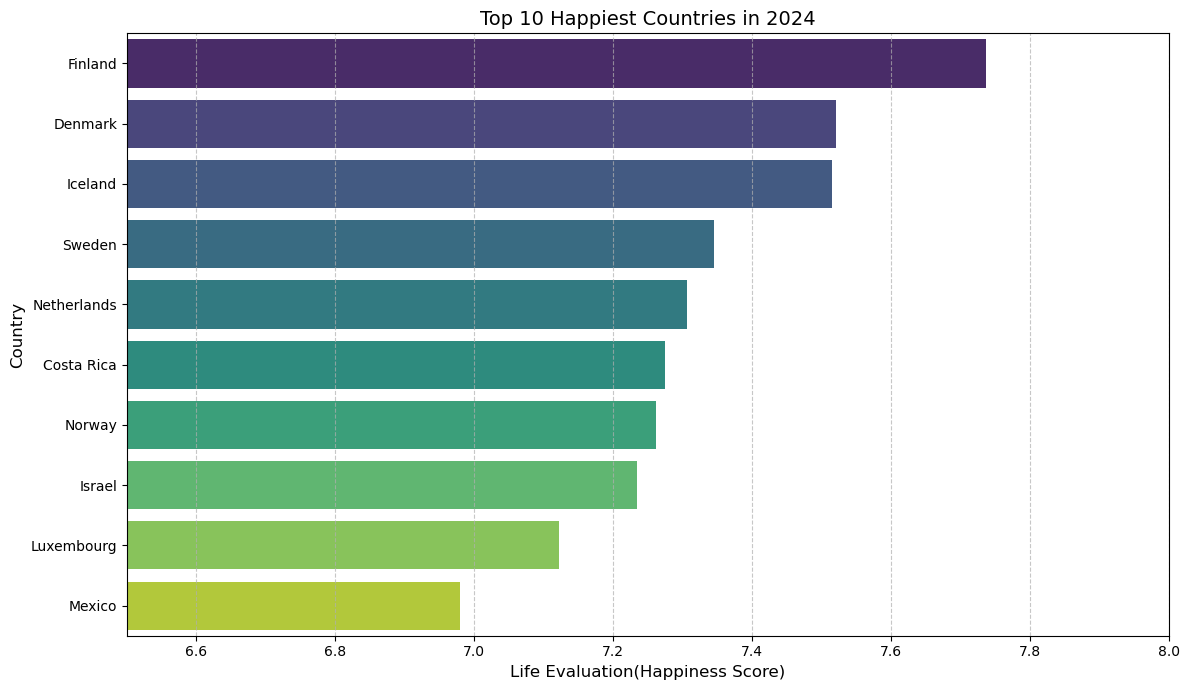

In [61]:
# plot
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_approx, 
            y='Country name', 
            x='Life evaluation (3-year average)', 
            palette='viridis')  

plt.title('Top 10 Happiest Countries in 2024',fontsize=14)
plt.xlabel('Life Evaluation(Happiness Score)',fontsize=12)
plt.ylabel('Country',fontsize=12)
plt.xlim(6.5, 8) 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<small>
From the above figure we conclude that the Nordic countries dominate the top ranks, with Finland leading for the eighth consecutive year due to strong social support, low corruption, and excellent work-life balance.We also observe a surprising rise of Latin American nations like Costa Rica (6th) and Mexico (10th), showing that strong family ties and social connections can outweigh lower GDP in driving happiness.
</small>

## Correlation Analysis

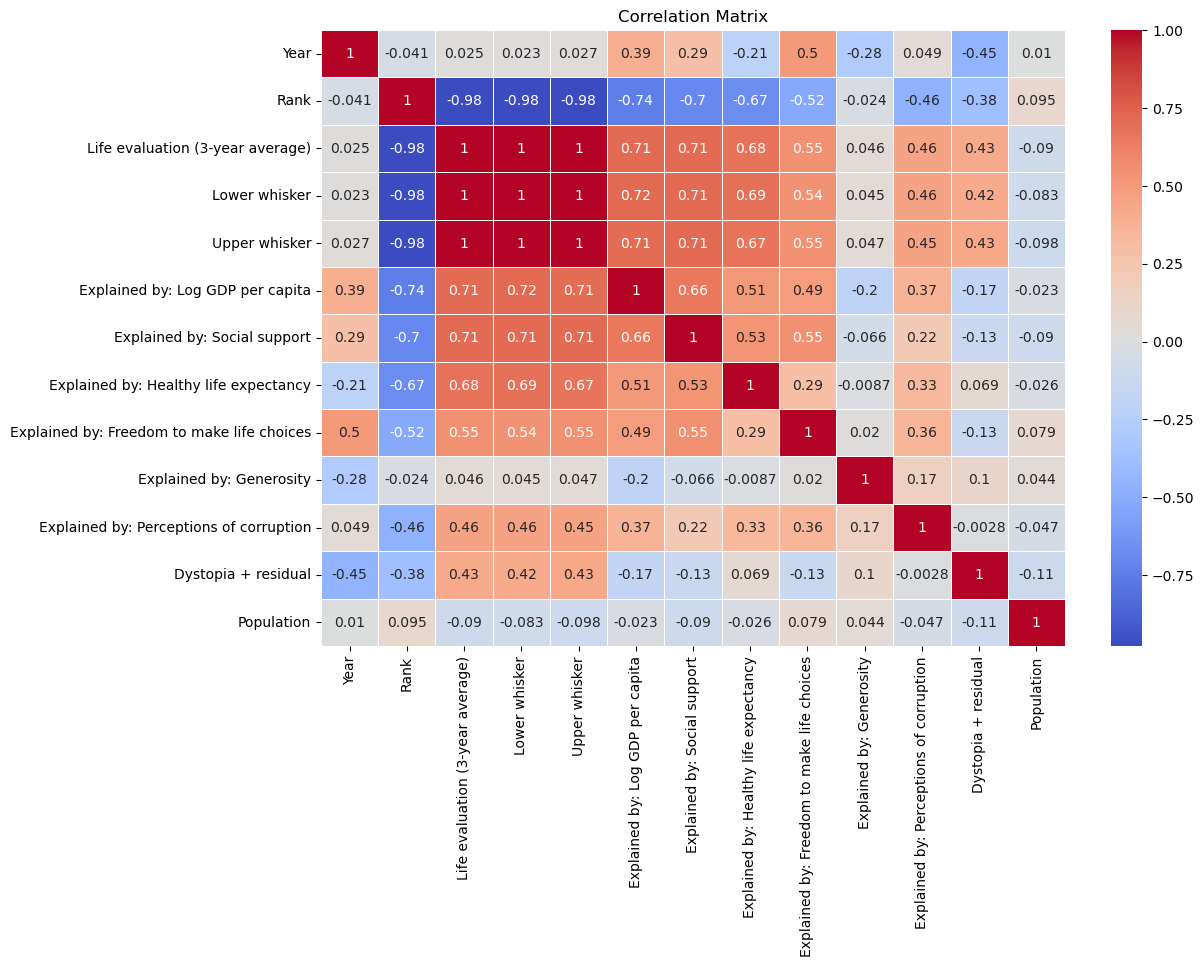

In [62]:
# Select numeric columns
numeric_columns=df_final.select_dtypes(include=['float64','Int64']).columns

# Compute correlation matrix
corr_matrix=df_final[numeric_columns].corr()

# plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<small>
From the correlation matrix, we conclude that happiness score (Life evaluation) is strongly negatively correlated with Rank , confirming that higher scores directly improve rankings, and moderately to strongly positively correlated with Log GDP per capita, Social support, and Healthy life expectancy , showing these are the main drivers of national happiness differences.Freedom to make life choices and Perceptions of corruption also contribute meaningfully , while Generosity has almost no correlation , indicating it plays a very minor role compared to economic, social, and health factors.Year shows weak correlations with most variables, suggesting limited overall time trends in the dataset, though some negative links (e.g., with Dystopia + residual) hint at evolving unexplained factors across years.
</small>

### 2. What are the regional differences in average happiness scores ?

C:\Users\HP\AppData\Local\Temp\ipykernel_9148\476617976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_LifeLadder_by_region,x='Region', y='Life evaluation (3-year average)',palette='viridis')


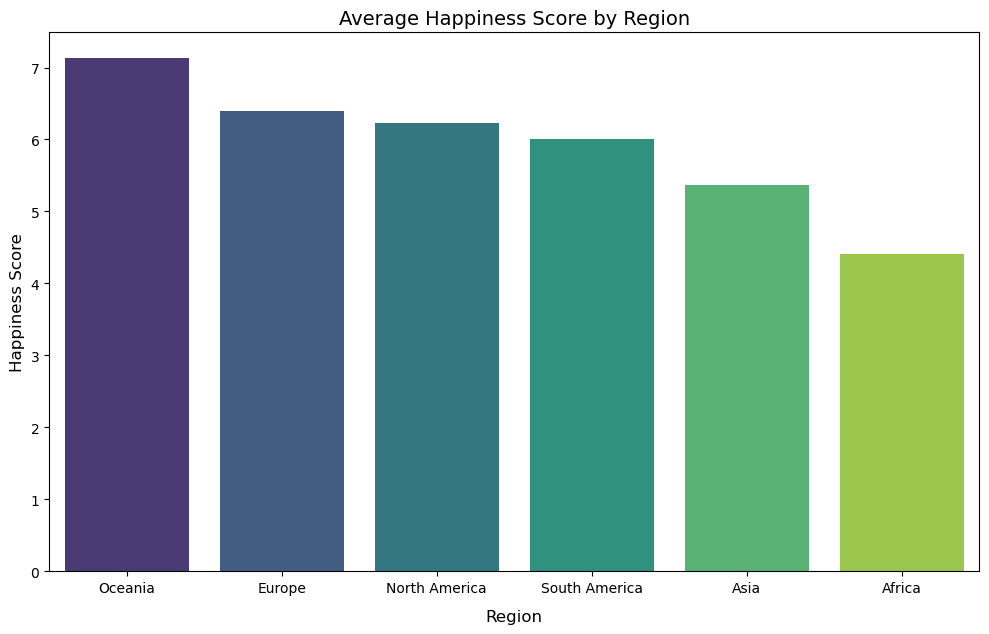

In [63]:
# Average happiness by region
avg_LifeLadder_by_region=(df_final.groupby('Region')['Life evaluation (3-year average)'].mean()
                        .sort_values(ascending=False).reset_index())

# plot
plt.figure(figsize=(12, 7))
sns.barplot(data=avg_LifeLadder_by_region,x='Region', y='Life evaluation (3-year average)',palette='viridis')
plt.title('Average Happiness Score by Region',fontsize=14)
plt.xlabel('Region',fontsize=12,labelpad=10)
plt.ylabel("Happiness Score",fontsize=12)
plt.show()


<small> From this bar chart, we conclude that Oceania leads with the highest average happiness score , followed by Europe and North America, while Africa has the lowest , highlighting significant global well-being gaps between wealthier and developing regions </small>



### 3. How strongly does average GDP per capita correlate with average happiness across countries?



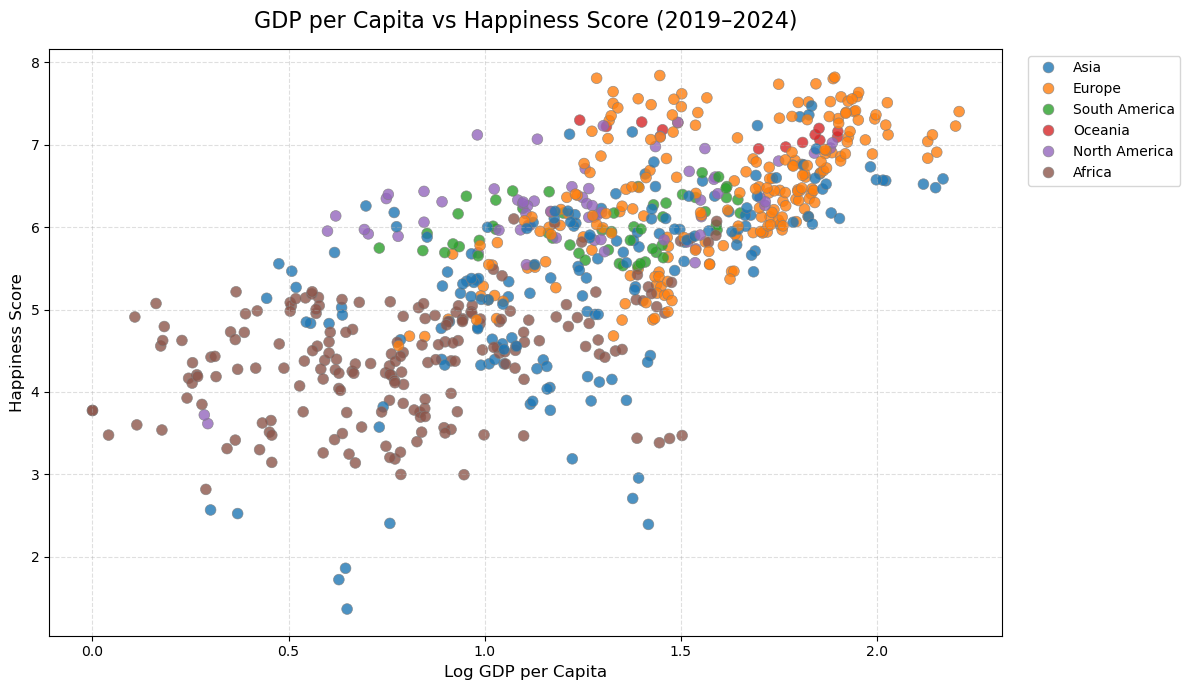

In [64]:
# Average metrics by country
df_avg = df_final.groupby('Country name').agg({
    'Explained by: Log GDP per capita': 'mean',
    'Life evaluation (3-year average)': 'mean',
    'Region': 'first',
    'Population': 'mean'
}).reset_index()

# plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_final,
    x='Explained by: Log GDP per capita',
    y='Life evaluation (3-year average)',
    hue='Region',
    s=60,                            
    alpha=0.8,
    legend='brief',
    edgecolor='gray',                
    linewidth=0.5
)

plt.title('GDP per Capita vs Happiness Score (2019–2024)', fontsize=16, pad=15)
plt.xlabel('Log GDP per Capita', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

<small>
From the above figure, we can see GDP per capita shows a strong positive relationship with Happiness Score, with diminishing returns at higher income levels.Wealth explains much of cross-country happiness variation, though other factors cause noticeable scatter.
</small>

### 4. What role does social support play in overall happiness rankings over the years?



In [65]:
# Calculate correlation
correlation=df_final['Explained by: Social support'].corr(
    df_final['Life evaluation (3-year average)']
)

print(f"Correlation: {correlation:.3f}")

Correlation: 0.711


<small>
From this code, we conclude that social support has a strong positive correlation (r = 0.711) with life evaluation, indicating that higher perceived social support significantly contributes to greater overall happiness.

</small>

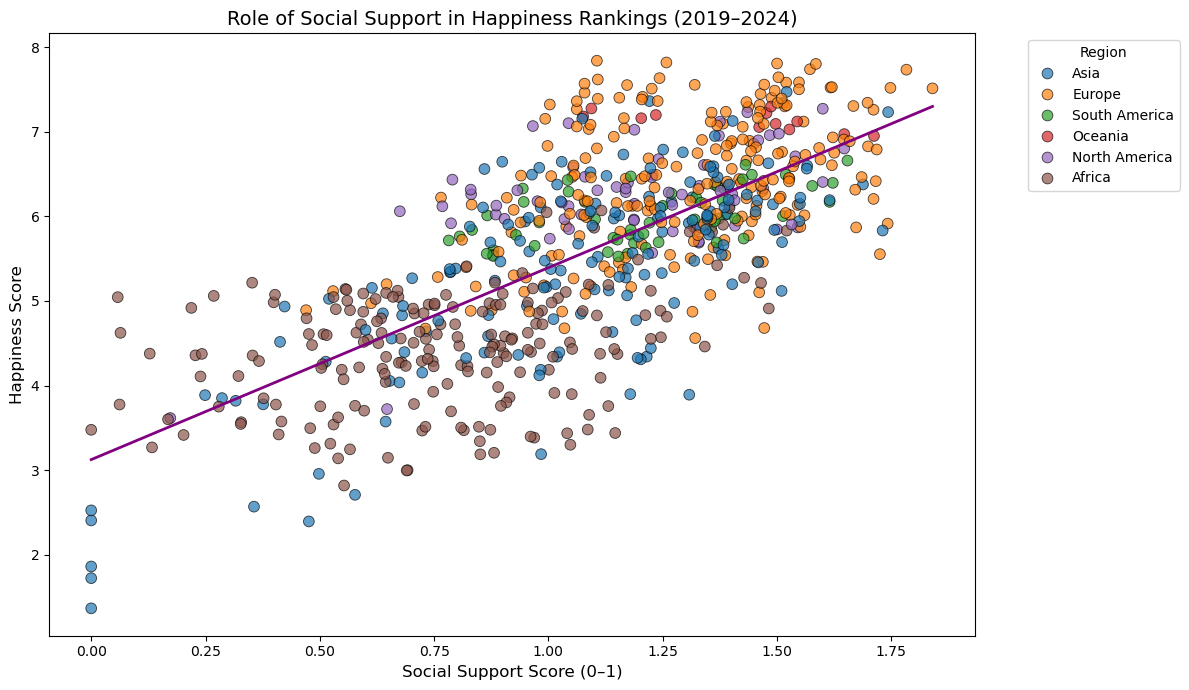

In [66]:
# Average metrics by country
df_final_avg = df_final.groupby('Country name').agg({
    'Explained by: Social support': 'mean',
    'Life evaluation (3-year average)': 'mean',
    'Region': 'first',
    'Population': 'mean'
}).reset_index()

# plot
plt.figure(figsize=(12,7))

sns.scatterplot(
    data=df_final,
    x='Explained by: Social support',
    y='Life evaluation (3-year average)',
    hue='Region',
    s=60,
    alpha=0.7,
    edgecolor='black'
)


sns.regplot(
    data=df_final,
    x='Explained by: Social support',
    y='Life evaluation (3-year average)',
    scatter=False,
    color='purple',
    line_kws={'linewidth': 2},
    ci=None
)

plt.title('Role of Social Support in Happiness Rankings (2019–2024)', fontsize=14)
plt.xlabel('Social Support Score (0–1)', fontsize=12)
plt.ylabel('Happiness Score',fontsize=12)

plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<small>
From this plot, we conclude that through years, higher social support scores are strongly and positively correlated with higher happiness rankings across all regions

</small>

### 5. What is the overall trend in the global average happiness score from 2019 to 2024?



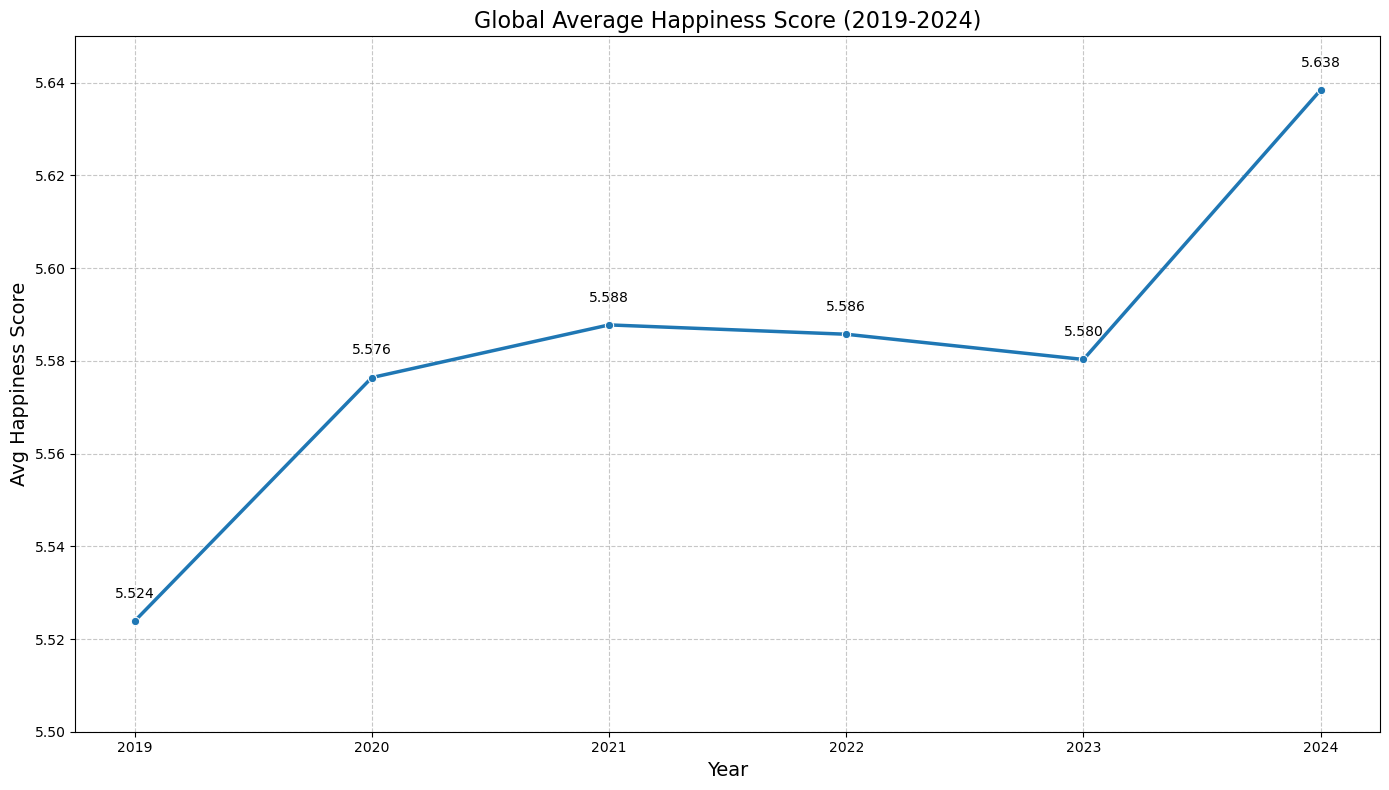

In [67]:
# Calculate yearly average happiness
yearly_avg= df_final.groupby('Year')['Life evaluation (3-year average)'].mean().reset_index()

# plot 
plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='Life evaluation (3-year average)', data=yearly_avg, marker='o', linewidth=2.5, color='#1f77b4')
plt.title('Global Average Happiness Score (2019-2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg Happiness Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(yearly_avg['Year'])
plt.ylim(5.50,5.65)


years = yearly_avg['Year'].values
for i, text in enumerate(yearly_avg['Life evaluation (3-year average)']):
    plt.text(
        years[i], 
        text + 0.005, 
        f'{text:.3f}', 
        ha='center', 
        fontsize=10
    )

plt.tight_layout()
plt.show()


<small> From this figure, we conclude that the global average happiness score rose steadily from 
5.524 in 2019 to 5.638 in 2024, showing an overall upward trend
<small>

### 6. How did happiness trends differ between the happiest and least happy Middle Eastern countries (2019–2024)?





In [68]:
# Define top and least countries
top_countries = ['United Arab Emirates', 'Kuwait', 'Saudi Arabia']
least_countries = ['Lebanon', 'Syria', 'Iraq','Yemen','Afghanistan']  

# Filter top data and least data
df_top = df_final[df_final['Country name'].isin(top_countries)]
df_least = df_final[df_final['Country name'].isin(least_countries)]

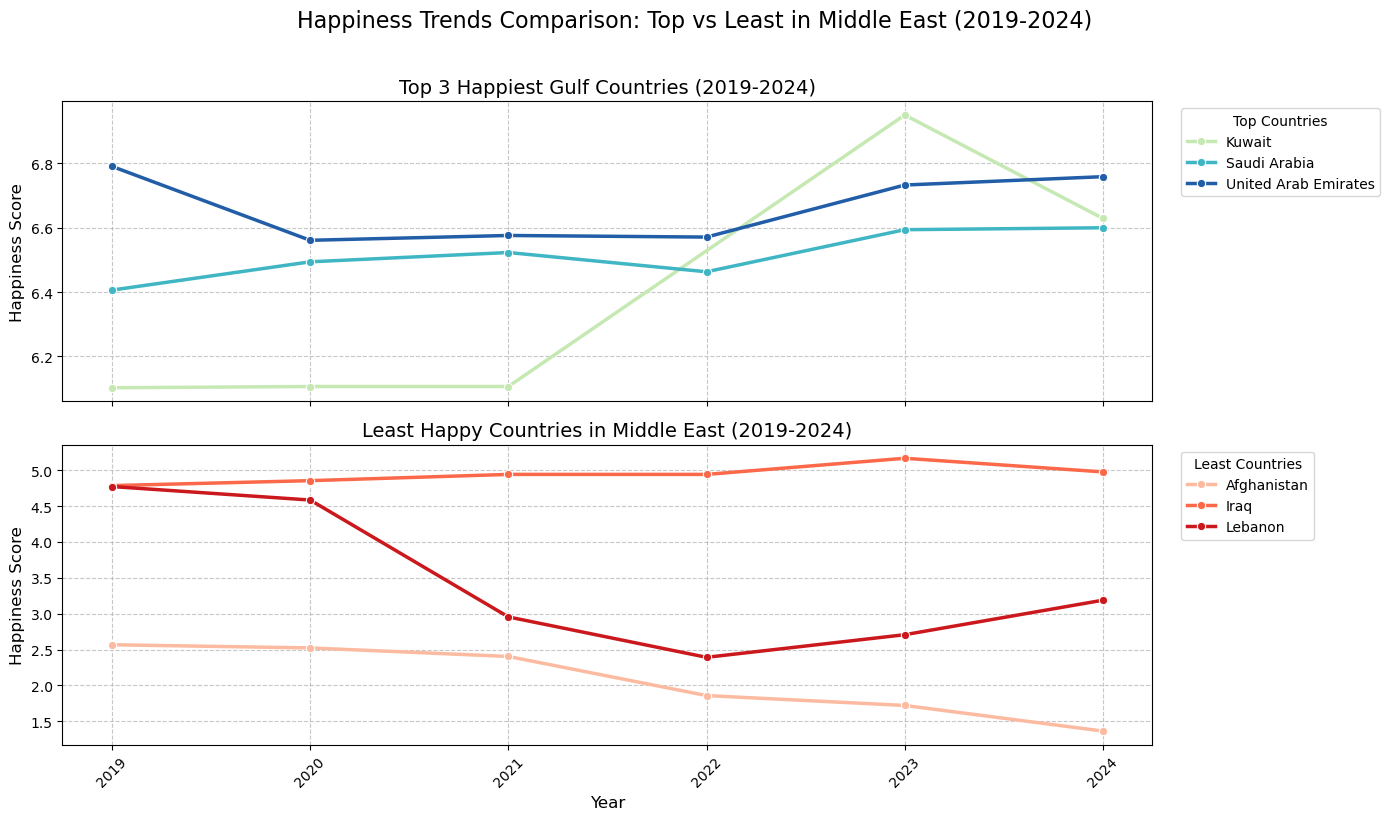

In [69]:

# plot
fig, ax = plt.subplots(2, 1, figsize=(14,8), sharex=True)  
sns.lineplot(
    data=df_top,
    x='Year',
    y='Life evaluation (3-year average)',
    hue='Country name',
    marker='o',
    linewidth=2.5,
    palette='YlGnBu',
    ax=ax[0],                
    legend='full'        
)

ax[0].set_title('Top 3 Happiest Gulf Countries (2019-2024)', fontsize=14)
ax[0].set_ylabel('Happiness Score', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend(title='Top Countries', bbox_to_anchor=(1.02, 1), loc='upper left')

sns.lineplot(
    data=df_least,
    x='Year',
    y='Life evaluation (3-year average)',
    hue='Country name',
    marker='o',
    linewidth=2.5,
    palette='Reds',
    ax=ax[1],              
    legend='full'
)



ax[1].set_title('Least Happy Countries in Middle East (2019-2024)', fontsize=14)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].set_ylabel('Happiness Score', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend(title='Least Countries', bbox_to_anchor=(1.02, 1), loc='upper left')
ax[1].tick_params(axis='x', rotation=45)


fig.suptitle('Happiness Trends Comparison: Top vs Least in Middle East (2019-2024)', 
            fontsize=16, y=1.02)

plt.tight_layout()   
plt.show()

<small>
From this figure, we conclude that top Gulf countries maintained stable or slightly increasing happiness scores (6.6–6.8), while least happy Middle Eastern countries showed sharp declines


</small>

<small></small>

### 7. How does healthy life expectancy influence happiness across developing regions?



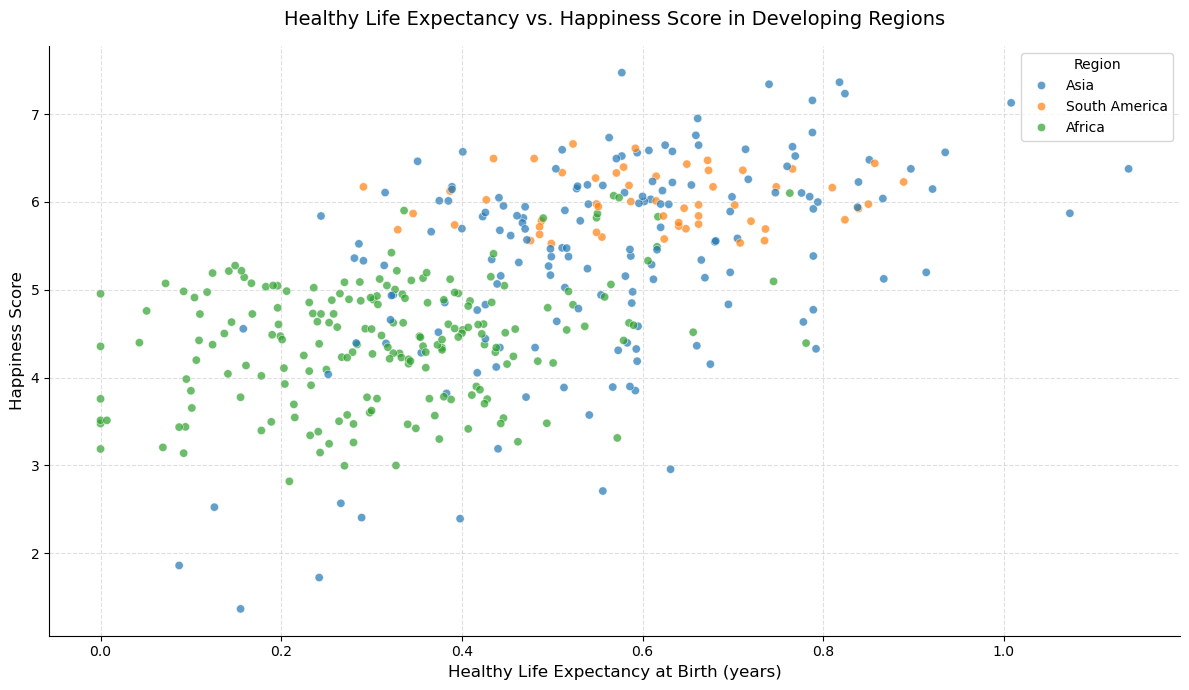

In [70]:
# Define developing regions
developing_regions = ['Asia', 'South America','Africa']

# Filter developing data
df_dev = df_final[df_final['Region'].isin(developing_regions)].copy()

# plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_dev, x='Explained by: Healthy life expectancy', y='Life evaluation (3-year average)', 
                hue='Region', alpha=0.7)


plt.title("Healthy Life Expectancy vs. Happiness Score in Developing Regions", fontsize=14, pad=15)
plt.xlabel("Healthy Life Expectancy at Birth (years)", fontsize=12)
plt.ylabel("Happiness Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)


sns.despine()
plt.tight_layout()
plt.show()


<small>
From this figure, we conclude that in developing regions, higher healthy life expectancy is positively correlated with higher happiness scores, with Asia and South America showing stronger improvements compared to Africa
</small>

### 8. How does perceived corruption vary across world regions, reflecting government satisfaction levels?



C:\Users\HP\AppData\Local\Temp\ipykernel_9148\2931307786.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'Satisfaction with Government by Region (Based on Low Perceived Corruption)')

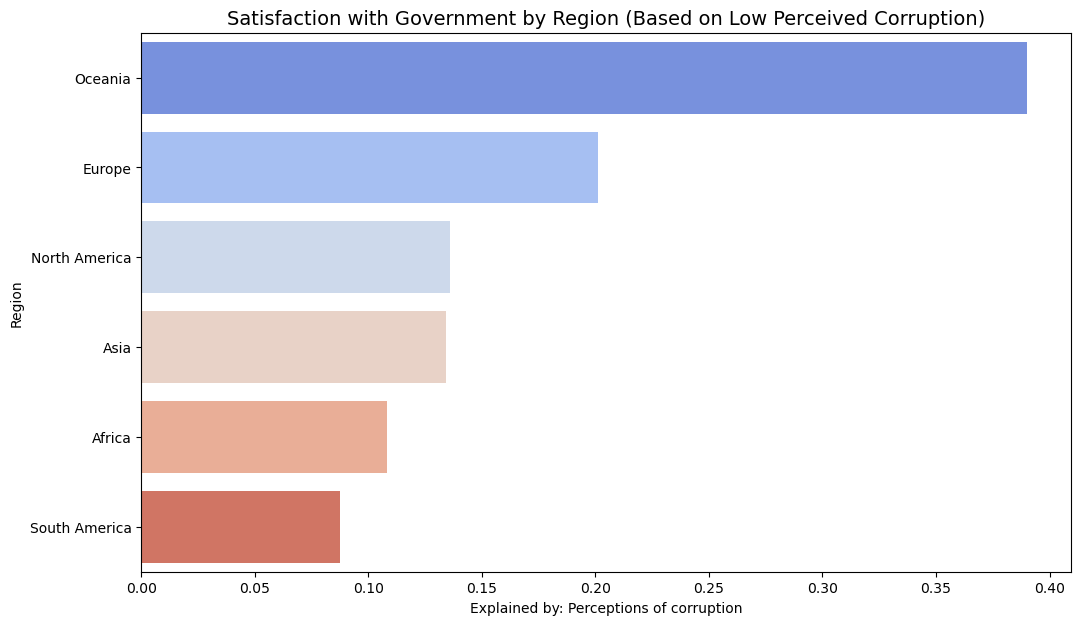

In [71]:

order = df_final.groupby('Region')['Explained by: Perceptions of corruption'].mean().sort_values(ascending=False).index

# plot
plt.figure(figsize=(12,7))
sns.barplot(
    x='Explained by: Perceptions of corruption',
    y='Region',
    data=df_final,
    palette='coolwarm',          
    order=order,
    errorbar=None                 
)
plt.title('Satisfaction with Government by Region (Based on Low Perceived Corruption)', fontsize=14)

<small> From this plot, we conclude that Oceania shows the highest perceived corruption (lowest government satisfaction), while South America and Africa have the lowest perceived corruption (highest relative satisfaction) </small>

